# **Importing Libraries**

In [1]:
import numpy as np
import glob
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms 
import torch.nn as nn  
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import shutil
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import DataLoader

# **Data Proccessing**

In [2]:
def load_image(image_path, resize = True):  
  img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
  return img

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
def imshow(img, title):
  img = img.numpy().transpose(1,2,0)
  mean = np.array([0.4914, 0.4822, 0.4465])
  std = np.array([0.2470, 0.2435, 0.2616])
  img = std*img + mean
  img = np.clip(img, 0, 1)
  plt.figure(figsize=(8,4))
  plt.imshow(img)
  plt.axis('off')
  plt.title(title)
  plt.show()

In [5]:
def imshow_masked(img):
  npimg = img.numpy()
  plt.figure(figsize = (3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [6]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageChops 
# train_path = '/kaggle/input/dl-dataset/Dataset/Training_Data/Masked_Train/'
# ground_truth_path = '/kaggle/input/dl-dataset/Dataset/Training_Data/Unmasked_Train/'
# train_mask_data = pd.read_csv(train_path + 'masked_info.csv').drop(['Unnamed: 0'],axis=1)
class ReconstructionDataset(Dataset):
  def __init__(self, flag_train, path, mask_path ="", masked_path = "", image_dims = (256, 256), n_channels = 3):
    self.path = path
    self.mask_path = mask_path
    self.masked_path = masked_path
    self.flag_train = flag_train
    self.list = os.listdir(path)
    self.image_dims = image_dims
    self.n_channels = n_channels
    self.resize = transforms.Resize(image_dims)
    self.to_tensor = transforms.ToTensor()
    
  def __len__(self):
    if(self.flag_train == 1):
        return len(self.list)
    return len(self.list) - 1
    
  def __getitem__(self, index):
    if torch.is_tensor(index):
            index = index.tolist()
    #print(index)
    if(self.flag_train):    
        filename = self.list[index]
#         mask_list = os.listdir(self.mask_path)
#         masked_img_list = os.listdir(self.masked_path)
        file = os.path.splitext(filename)
        image = Image.open(self.masked_path + filename)
        X_input = self.resize(image)
        mask = Image.open(self.mask_path + filename)
        X_mask = self.resize(mask)
        ground_truth = Image.open(self.path + filename)
        Y_output = self.resize(ground_truth)
        return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output)
    
    self.mask_data = pd.read_csv(self.path + 'masked_info.csv').drop(['Unnamed: 0'],axis=1)
    filename, y1, x1, y2, x2 = self.mask_data.loc[index,]
    image = Image.open(self.path + filename)
    X_input = self.resize(image)
    X_mask = self.Create_Mask(filename, self.mask_data)
    return self.to_tensor(X_input), self.to_tensor(X_mask), filename, x1, y1, x2, y2

#   def Create_Mask(self, image):
#     mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype = np.uint8)

#     for _ in range(np.random.randint(1, 10)):
#       x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])
#       y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])
#       thickness = np.random.randint(10,13)

#       cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)
        
  def Create_Mask(self, filename, dataset):
    y1, x1, y2, x2 = dataset[dataset['filename'] == filename].iloc[0,1:]
    mask = Image.new(mode="RGB", size=(256, 256))
    for i in range(x1, x1+75): 
        for j in range(y1, y1+75):
            mask.putpixel((i,j),(255,255,255)) # for every pixel:
    for i in range(x2, x2+75): 
        for j in range(y2, y2+75):
            mask.putpixel((i,j),(255,255,255)) # for every pixel:
    inverted = ImageChops.invert(mask)
    return(inverted)

In [7]:
Trainset = ReconstructionDataset(1, '/kaggle/input/dl-extra-training/Dataset/Training_Data/Unmasked_Train/', '/kaggle/input/dl-extra-training/Dataset/Training_Data/Masks/', '/kaggle/input/dl-extra-training/Dataset/Training_Data/Masked_Train/')
Testset = ReconstructionDataset(0, '/kaggle/input/dl-extra-training/Dataset/Testing_Data/')

In [8]:
Trainloader = DataLoader(Trainset, batch_size = 4, shuffle = True)
Testloader = DataLoader(Testset, batch_size = 4, shuffle = False)

Train_dataiter = iter(Trainloader)
Test_dataiter = iter(Testloader)

In [9]:
print(len(Trainloader))

3500


In [10]:
X_in, X_mask, Y_out = next(Train_dataiter)
print(X_in.shape, X_mask.shape, Y_out.shape)

torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])


Masked Image


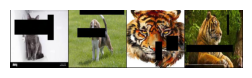

Masking Pattern


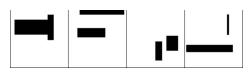

Original Image


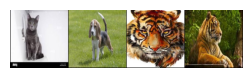

In [11]:

print('Masked Image')
imshow_masked(torchvision.utils.make_grid(X_in))
print('Masking Pattern')
imshow_masked(torchvision.utils.make_grid(X_mask))
print('Original Image')
imshow_masked(torchvision.utils.make_grid(Y_out))

# **Training**

In [12]:
layers = 7

In [13]:
class PartialConvLayer(nn.Module):
  def __init__(self, in_channels, out_channels, bn = True, bias = False, sample = "none-3", activation = "relu"):
    super().__init__()
    self.bn = bn
    self.activation = activation

    if sample == "down-7":
      self.input_conv = nn.Conv2d(in_channels, out_channels, 7, 2, 3, bias = bias)
      self.mask_conv = nn.Conv2d(in_channels, out_channels, 7, 2, 3, bias = False)

    elif sample == "down-5":
      self.input_conv = nn.Conv2d(in_channels, out_channels, 5, 2, 2, bias = bias)
      self.mask_conv = nn.Conv2d(in_channels, out_channels, 5, 2, 2, bias = False)

    elif sample == "down-3":
      self.input_conv = nn.Conv2d(in_channels, out_channels, 3, 2, 1, bias = bias)
      self.mask_conv = nn.Conv2d(in_channels, out_channels, 3, 2, 1, bias = False)
    
    else:
      self.input_conv = nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=bias)
      self.mask_conv = nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False)
      
    nn.init.constant_(self.mask_conv.weight, 1.0)
    nn.init.kaiming_normal_(self.input_conv.weight, a = 0, mode = "fan_in")

    for param in self.mask_conv.parameters():
      param.requires_grad = False

    if bn:
      self.batch_normalization = nn.BatchNorm2d(out_channels)

    if activation == "relu":
      self.activation = nn.ReLU()
    elif activation == "leaky_relu":
      self.activation == nn.LeakyReLU(negative_slope = 0.2)

  def forward(self, input_x, mask):
    output = self.input_conv(input_x * mask)
    with torch.no_grad():
      output_mask = self.mask_conv(mask)
    
    if self.input_conv.bias is not None:
      output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(output)
    else:
      output_bias = torch.zeros_like(output)

    mask_is_zero = (output_mask == 0)
    mask_sum = output_mask.masked_fill_(mask_is_zero, 1.0)

    output = (output - output_bias) / mask_sum + output_bias
    output = output.masked_fill(mask_is_zero, 0.0)

    new_mask = torch.ones_like(output)
    new_mask = new_mask.masked_fill_(mask_is_zero, 0.0)

    if self.bn:
      output = self.batch_normalization(output)
    #if hasattr(self, 'activation'):
      #output = self.activation(output)

    return output, new_mask

class PartialConvUNet(nn.Module):
  def __init__(self, input_size = 256, layer = 7):
    if 2**(layers + 1) != input_size:
      raise AssertionError

    super().__init__()
    self.freeze_enc_bn = False
    self.layers = layers

    self.encoder_1 = PartialConvLayer(3, 64, bn=False, sample="down-7")
    self.encoder_2 = PartialConvLayer(64, 128, sample="down-5")
    self.encoder_3 = PartialConvLayer(128, 256, sample="down-3")
    self.encoder_4 = PartialConvLayer(256, 512, sample="down-3")

    for i in range(5, layers + 1):
      name = "encoder_{:d}".format(i)
      setattr(self, name, PartialConvLayer(512, 512, sample="down-3"))
   
    for i in range(5, layers + 1):
      name = "decoder_{:d}".format(i)
      setattr(self, name, PartialConvLayer(512 + 512, 512, activation="leaky_relu"))
   
    self.decoder_4 = PartialConvLayer(512 + 256, 256, activation="leaky_relu")
    self.decoder_3 = PartialConvLayer(256 + 128, 128, activation="leaky_relu")
    self.decoder_2 = PartialConvLayer(128 + 64, 64, activation="leaky_relu")
    self.decoder_1 = PartialConvLayer(64 + 3, 3, bn=False, activation="", bias=True)

  def forward(self, input_x, mask):
    encoder_dict = {}
    mask_dict = {}
    key_prev = "h_0"
    encoder_dict[key_prev], mask_dict[key_prev] = input_x, mask

    for i in range(1, self.layers + 1):
      encoder_key = "encoder_{:d}".format(i)
      key = "h_{:d}".format(i)
      encoder_dict[key], mask_dict[key] = getattr(self, encoder_key)(encoder_dict[key_prev], mask_dict[key_prev])
      key_prev = key

    out_key = "h_{:d}".format(self.layers)
    out_data, out_mask = encoder_dict[out_key], mask_dict[out_key]

    for i in range(self.layers, 0, -1):
      encoder_key = "h_{:d}".format(i - 1)
      decoder_key = "decoder_{:d}".format(i)
      out_data = F.interpolate(out_data, scale_factor=2)
      out_mask = F.interpolate(out_mask, scale_factor=2)
      out_data = torch.cat([out_data, encoder_dict[encoder_key]], dim=1)
      out_mask = torch.cat([out_mask, mask_dict[encoder_key]], dim=1)
      out_data, out_mask = getattr(self, decoder_key)(out_data, out_mask)
    return out_data

  def train(self, mode=True):
    super().train(mode)
    if self.freeze_enc_bn:
      for name, module in self.named_modules():
        if isinstance(module, nn.BatchNorm2d) and "enc" in name:
          module.eval()

In [14]:
def Dice_coeff(dataloader):
  for (X_input, X_mask, Y_output) in dataloader:
    X_input, X_mask, Y_output = X_input.to(device), X_mask.to(device), Y_output.to(device)
    outputs = model(X_input, X_mask)
    eps = 1e-15
    outputs = outputs.view(-1)
    Y_output = Y_output.view(-1)
    intersection = (outputs * Y_output).sum()
    sum = (outputs.sum() + Y_output.sum())
  return (2*(intersection) / (sum + eps))

In [15]:
model = PartialConvUNet().to(device)
model = model.to(device)
#model.load_state_dict(torch.load('/kaggle/input/ckpt-pconvnet/1000000.pth'), strict=False)

In [16]:
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr = 0.001)
for param_group in opt.param_groups:
    print(param_group['lr'])

0.001


Epoch Running: 0
Min loss 0.31698
Iteration: 0/3500, Loss: 0.31698
Min loss 0.24579
Min loss 0.23417
Min loss 0.20986
Min loss 0.19066
Min loss 0.16986
Min loss 0.14460
Min loss 0.11735
Min loss 0.10839
Iteration: 100/3500, Loss: 0.22274
Min loss 0.07797
Min loss 0.06924
Min loss 0.06863
Min loss 0.06146
Min loss 0.06111
Min loss 0.05361
Iteration: 200/3500, Loss: 0.10017
Min loss 0.04599
Min loss 0.04473
Min loss 0.04336
Min loss 0.04305
Min loss 0.03143
Min loss 0.02950
Iteration: 300/3500, Loss: 0.07721
Min loss 0.02345
Iteration: 400/3500, Loss: 0.08271
Min loss 0.01920
Iteration: 500/3500, Loss: 0.03567
Iteration: 600/3500, Loss: 0.02433
Min loss 0.01908
Iteration: 700/3500, Loss: 0.03822
Min loss 0.01834
Min loss 0.01708
Iteration: 800/3500, Loss: 0.03089
Iteration: 900/3500, Loss: 0.04523
Iteration: 1000/3500, Loss: 0.03092
Min loss 0.01625
Iteration: 1100/3500, Loss: 0.02468
Min loss 0.01622
Min loss 0.01407
Iteration: 1200/3500, Loss: 0.05565
Min loss 0.01355
Min loss 0.01300


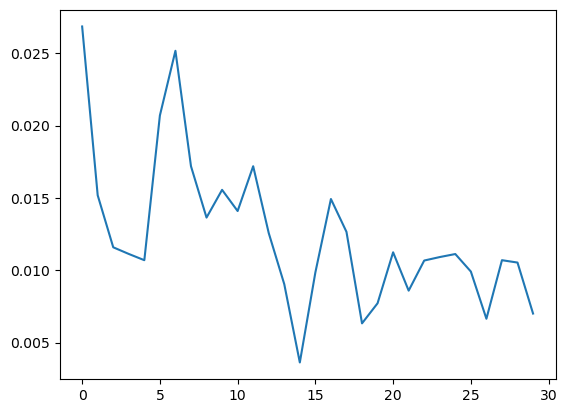

In [17]:
loss_epoch_arr = []
max_epochs = 30
batch_size = 4
min_loss = 1000

best_epoch = 0
n_iters = np.ceil(14000/batch_size)
for epoch in range(max_epochs):
    print(f'Epoch Running: {epoch}')
    model.train()                               
    for i, (X_input, X_mask, Y_output) in enumerate(Trainloader, 0):

        X_input, X_mask, Y_output = X_input.to(device), X_mask.to(device), Y_output.to(device)

        opt.zero_grad()

        outputs = model(X_input, X_mask)
        loss = loss_fn(Y_output, outputs)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            print('Min loss %0.5f' % min_loss)
            best_epoch = epoch
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.005f' % (i, n_iters, loss.item()))
            
        del X_input, X_mask, Y_output
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
print(f'The best epoch is {best_epoch}')
plt.plot(loss_epoch_arr)
plt.show()

In [18]:
model.load_state_dict(best_model)
torch.save(model,'/kaggle/working/pconv.pth')

# **Testing**

In [19]:
import cv2 as cv
trans = transforms.ToPILImage()
def Create_Mask(filename, dataset):
    y1, x1, y2, x2 = dataset[dataset['filename'] == filename].iloc[0,1:]
    mask = Image.new(mode="RGB", size=(256, 256))
    for i in range(x1, x1+75): 
        for j in range(y1, y1+75):
            mask.putpixel((i,j),(255,255,255)) # for every pixel:
    for i in range(x2, x2+75): 
        for j in range(y2, y2+75):
            mask.putpixel((i,j),(255,255,255)) # for every pixel:
    inverted = ImageChops.invert(mask)
    return(inverted)

    image = np.asarray(image)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image, mask

test_path = '/kaggle/input/dl-extra-training/Dataset/Testing_Data/'
to_tensor = transforms.ToTensor()
#transform = T.ToPILImage()
import numpy as np
#from google.colab.patches import cv2_imshow
def submission_data(test_path):
    test_mask_data = pd.read_csv(test_path + 'masked_info.csv').drop(['Unnamed: 0'],axis=1)
    submission = []
    for i, (sample_inputs, sample_masks, filename, x1, y1, x2, y2) in enumerate(Testloader, 0):
        if (i%25 == 0):
            print("Nigga 25 iterations ho gyi:" , i)
        
        #sample_inputs, sample_masks, filename, x1, y1, x2, y2= next(Test_dataiter)
        sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()
        #model.load_state_dict(torch.load('/kaggle/input/ckpt-pconvnet/1000000.pth'), strict=False)
        model.eval()
        with torch.no_grad():
            preds = model(sample_inputs, sample_masks)
#         import matplotlib.pyplot as plt
#         plt.imshow(preds)
#         print(preds.size())
        for batch in range(4):
            
            pred = trans(preds[batch])
#             import matplotlib.pyplot as plt
#             plt.imshow(pred)
            im = np.array(pred)
            #print(im)
            b, g, r = cv.split(im)
            result = np.zeros((256,256))
            normalized_b = cv.normalize(b,result, 0, 1, cv.NORM_MINMAX, dtype=cv.CV_32F)
            normalized_g = cv.normalize(g,result, 0, 1, cv.NORM_MINMAX, dtype=cv.CV_32F)
            normalized_r = cv.normalize(r,result, 0, 1, cv.NORM_MINMAX, dtype=cv.CV_32F)
#             for i in range(256):
#                 for j in range(256):
#                     temp1 = filename[batch] + '_' + 'box1' + '_' +  str(i) + '_' + str(j) + '_'
#                     submission.append((temp1 + '0', normalized_b[i,j]))
#                     submission.append((temp1 + '1', normalized_g[i,j]))
#                     submission.append((temp1 + '2', normalized_r[i,j]))
                    
            #print(filename[batch])
            for i in range(y1[batch].item() , y1[batch].item()+75):
                for j in range(x1[batch].item(), x1[batch].item()+75):
                    temp1 = filename[batch] + '_' + 'box1' + '_' +  str(i) + '_' + str(j) + '_'
                    submission.append((temp1 + '0', normalized_b[i,j]))
                    submission.append((temp1 + '1', normalized_g[i,j]))
                    submission.append((temp1 + '2', normalized_r[i,j]))
            for i in range(y2[batch].item() , y2[batch].item()+75):
                for j in range(x2[batch].item(), x2[batch].item()+75):
                    temp1 = filename[batch] + '_' + 'box2' + '_' + str(i) + '_' + str(j) + '_'
                    submission.append((temp1 + '0', normalized_b[i,j]))
                    submission.append((temp1 + '1', normalized_g[i,j]))
                    submission.append((temp1 + '2', normalized_r[i,j]))
            df = pd.DataFrame(submission, columns=['filename_box_pixel','value'])
    return(df)

In [20]:
df = submission_data(test_path)
df.to_csv('/kaggle/working/submission.csv',index=False)

Nigga 25 iterations ho gyi: 0
Nigga 25 iterations ho gyi: 25


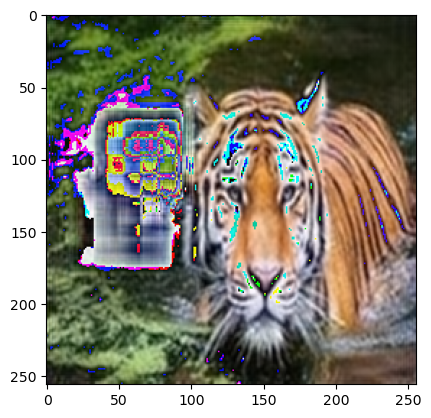

In [21]:
sample_inputs, sample_masks, filename, x1, y1, x2, y2= next(Test_dataiter)
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()
model.eval()
with torch.no_grad():
    preds = model(sample_inputs, sample_masks)

pred = trans(preds[0])
import matplotlib.pyplot as plt
plt.imshow(pred)

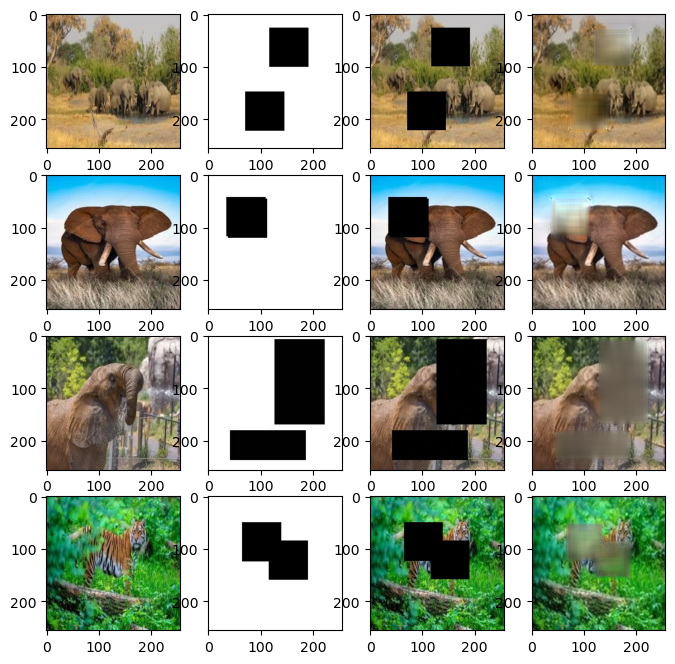

In [22]:
sample_inputs, sample_masks, sample_truths = next(Train_dataiter)
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))